In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pyodbc
import datetime as dt

from scipy.cluster.hierarchy import linkage, dendrogram

In [15]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                            'SERVER=L_AAGDATIX;'
                            'DATABASE=DatixCRM;'
                            'Trusted_Connection=yes') 
query = "set transaction isolation level read uncommitted select inc_dincident,inc_time,inc_dreported,inc_submittedtime,inc_organisation,inc_locactual,inc_unit,inc_specialty,inc_loctype,inc_result,inc_severity,show_other_contacts,show_employee,show_witness,show_document,inc_reportedby,inc_notes from DatixCRM.dbo.incidents_main where inc_type='PAT' and inc_category='MEDIC'"
df = pd.read_sql(query, sql_conn)
df.head()

,inc_dincident,inc_time,inc_dreported,inc_submittedtime,inc_organisation,inc_locactual,inc_unit,inc_specialty,inc_loctype,inc_result,inc_severity,show_other_contacts,show_employee,show_witness,show_document,inc_reportedby,inc_notes
0,2016-03-31,0800,2016-03-31,2025,QA,E6/7,MEDMED,RESP,WARD,NOHARM,NONE,None,N,N,N,None,on drug rounds found Amlodipine not given for ...
1,2016-03-31,2100,2016-04-01,1553,QA,C5,MEDMED,GENMED,WARD,HARM,LOW,None,Y,Y,Y,None,HAEMOPHILIA PATIENT\r\n\r\nPATIENT NOT ADMINIS...
2,2016-04-01,1957,2016-04-01,2002,QA,EMERG,MEDUR,ED,AE,NOHARM,NONE,None,N,N,N,Other,"Resus controlled order booked went missing, ha..."
3,2016-03-25,1400,2016-04-01,2126,QA,C7,MEDMED,CARDIO,WARD,NOHARM,NONE,None,Y,N,N,Other (Nurse / Midwife ),MIDAZOLAM SIGNED OUT OF CD BOOK FOR PATIENT . ...
4,2016-04-02,0730,2016-04-02,0752,QA,D5,SURMHN,ORTHO,WARD,NOHARM,NONE,None,N,N,N,Nurse,I was giving the oral medication(CD-oxycodone)...


In [16]:
df['division'] = df['inc_unit'].str[:3]
df['care group'] = df['inc_unit'].str[3:6]
df = df.drop('inc_unit',axis=1)

In [17]:
df.columns = [column.replace('inc_organisation','site') for column in df.columns]
df.columns = [column.replace('inc_locactual','ward/dept/unit') for column in df.columns]
df.columns = [column.replace('inc_unit','division & care group') for column in df.columns]
df.columns = [column.replace('inc_specialty','specialty') for column in df.columns]
df.columns = [column.replace('inc_loctype','location type') for column in df.columns]
df.columns = [column.replace('inc_result','result') for column in df.columns]
df.columns = [column.replace('inc_severity','severity') for column in df.columns]
df.columns = [column.replace('inc_reportedby','reported by') for column in df.columns]
df.columns = [column.replace('show_other_contacts','other patients involved?') for column in df.columns]
df.columns = [column.replace('show_employee','other employees involved?') for column in df.columns]
df.columns = [column.replace('show_witness','any witnesses?') for column in df.columns]
df.columns = [column.replace('show_document','any documents attached?') for column in df.columns]
df.head()

,inc_dincident,inc_time,inc_dreported,inc_submittedtime,site,ward/dept/unit,specialty,location type,result,severity,other patients involved?,other employees involved?,any witnesses?,any documents attached?,reported by,inc_notes,division,care group
0,2016-03-31,0800,2016-03-31,2025,QA,E6/7,RESP,WARD,NOHARM,NONE,None,N,N,N,None,on drug rounds found Amlodipine not given for ...,MED,MED
1,2016-03-31,2100,2016-04-01,1553,QA,C5,GENMED,WARD,HARM,LOW,None,Y,Y,Y,None,HAEMOPHILIA PATIENT\r\n\r\nPATIENT NOT ADMINIS...,MED,MED
2,2016-04-01,1957,2016-04-01,2002,QA,EMERG,ED,AE,NOHARM,NONE,None,N,N,N,Other,"Resus controlled order booked went missing, ha...",MED,UR
3,2016-03-25,1400,2016-04-01,2126,QA,C7,CARDIO,WARD,NOHARM,NONE,None,Y,N,N,Other (Nurse / Midwife ),MIDAZOLAM SIGNED OUT OF CD BOOK FOR PATIENT . ...,MED,MED
4,2016-04-02,0730,2016-04-02,0752,QA,D5,ORTHO,WARD,NOHARM,NONE,None,N,N,N,Nurse,I was giving the oral medication(CD-oxycodone)...,SUR,MHN


In [18]:
df['inc_time'] = df['inc_time'].str.replace(':','')
df['inc_submittedtime'] = df['inc_submittedtime'].str.replace(':','')

In [19]:
df['inc_year'] = df.inc_dincident.dt.year
df['inc_month'] = df.inc_dincident.dt.month
df['inc_day'] = df.inc_dincident.dt.day
df['inc_week'] = df.inc_dincident.dt.week
df['inc_weekday'] = df.inc_dincident.dt.weekday
df['inc_quarter'] = df.inc_dincident.dt.quarter
df['inc_hour'] = df['inc_time'].str[:2]
df['inc_minute'] = df['inc_time'].str[2:4]
df = df.astype({'inc_hour':'int'})
df = df.astype({'inc_minute':'int'})
df['inc_datetime'] = df.apply(lambda x: x.loc['inc_dincident'] + dt.timedelta(hours=x.loc['inc_hour'],minutes=x.loc['inc_minute']), axis=1)
df['reported_year'] = df.inc_dreported.dt.year
df['reported_month'] = df.inc_dreported.dt.month
df['reported_day'] = df.inc_dreported.dt.day
df['reported_week'] = df.inc_dreported.dt.week
df['reported_weekday'] = df.inc_dreported.dt.weekday
df['reported_quarter'] = df.inc_dreported.dt.quarter
df['reported_hour'] = df['inc_submittedtime'].str[:2]
df['reported_minute'] = df['inc_submittedtime'].str[2:4]
df = df.astype({'reported_hour':'int'})
df = df.astype({'reported_minute':'int'})
df['reported_datetime'] = df.apply(lambda x: x.loc['inc_dreported'] + dt.timedelta(hours=x.loc['reported_hour'],minutes=x.loc['reported_minute']), axis=1)
df['diff'] = df['reported_datetime'] - df['inc_datetime']
df['reported-incident'] = df['diff'] / np.timedelta64(1, 'D')
df.head()
df = df.drop(['inc_dincident','inc_time','inc_dreported','inc_submittedtime','inc_datetime','reported_datetime','diff'],axis=1)

In [20]:
df_category = df[['site','ward/dept/unit','specialty','location type','result','severity','reported by','division','care group']]

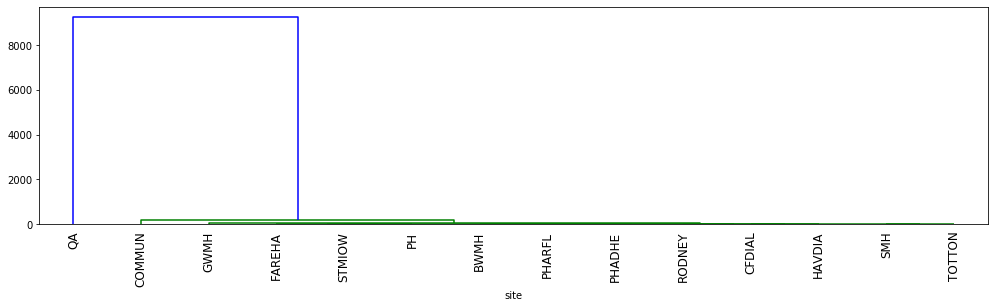

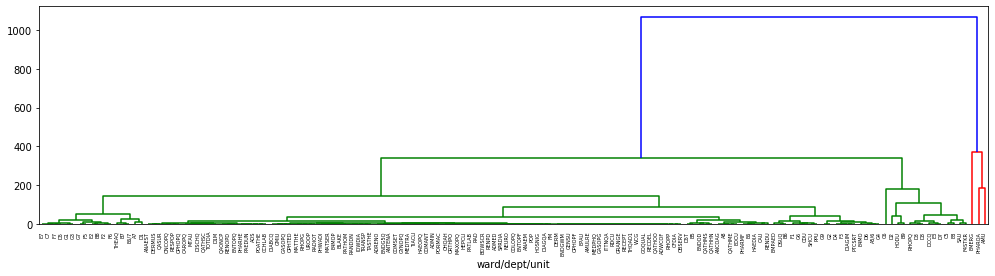

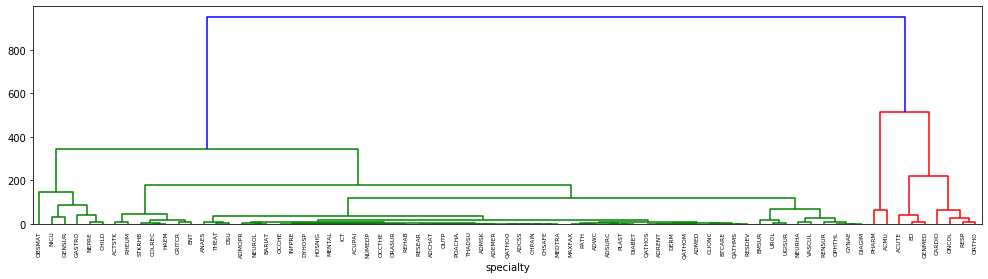

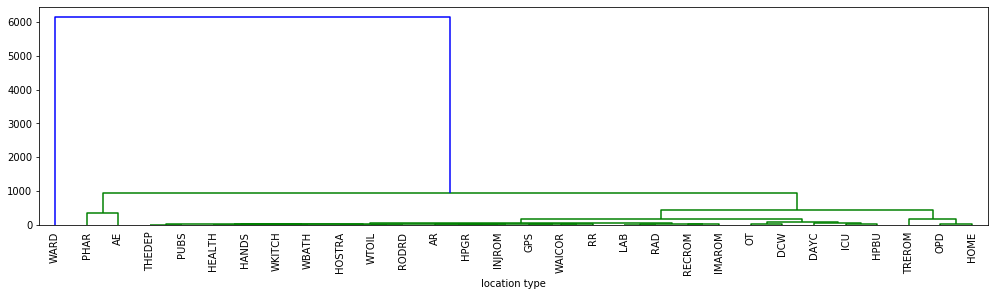

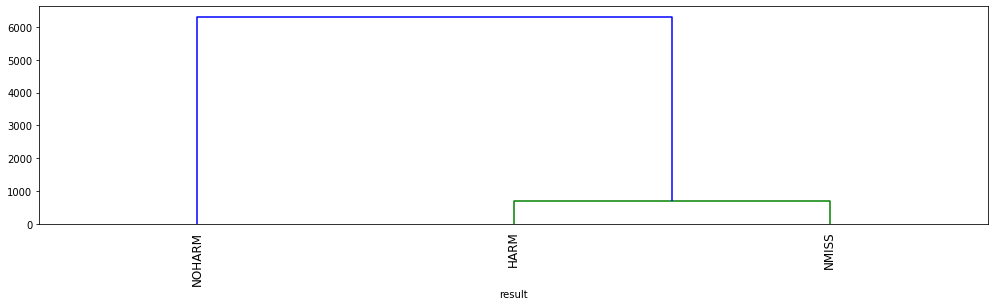

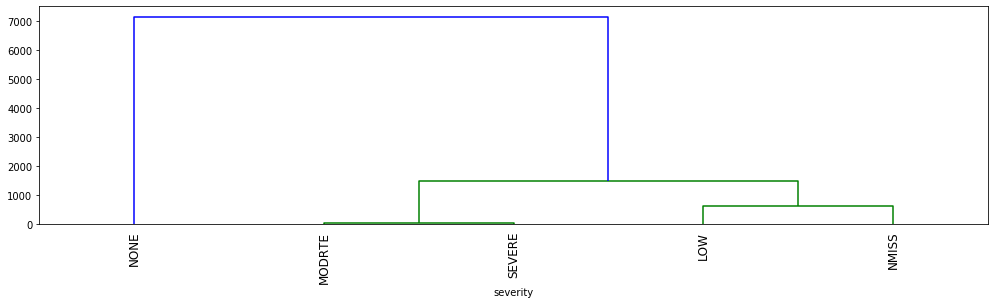

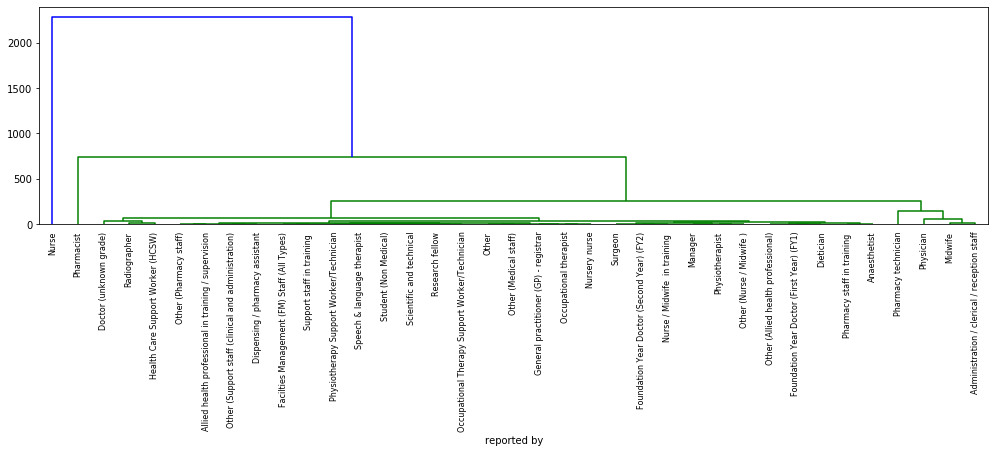

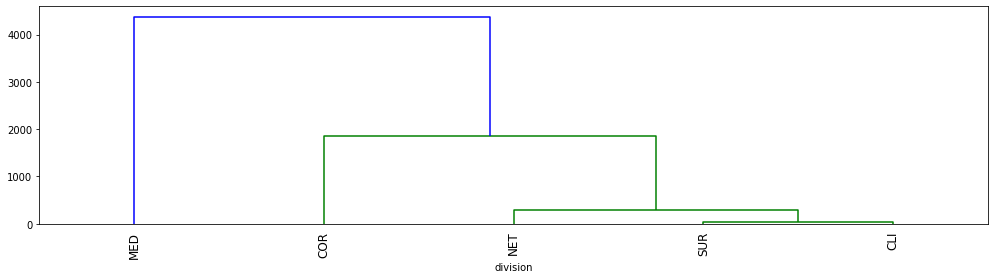

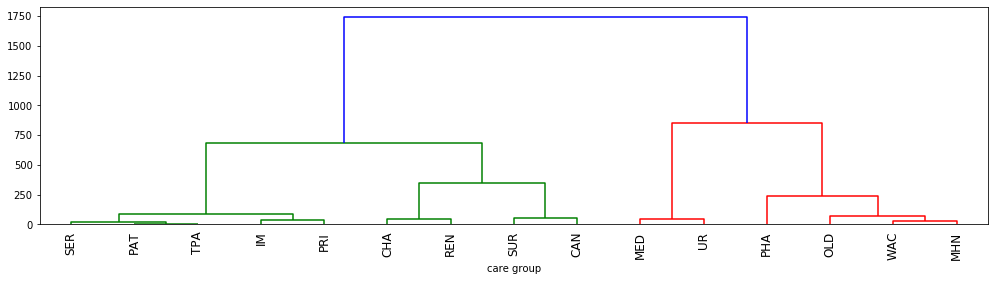

In [21]:
for column in df_category.columns:
    df_dropped = df_category.dropna(subset=[column])
    df_dropped = df_dropped[df_dropped[column]!='']
    counts = df_dropped[column].value_counts()

    # Calculate the linkage: mergings
    mergings = linkage(np.reshape(counts.values, (len(counts.values),1)),method='complete')

    # Plot the dendrogram, using varieties as labels
    plt.figure(figsize=(17,4))
    dendrogram(mergings,
               labels=list(counts.index),
               leaf_rotation=90,
#               leaf_font_size=7,
    );
    plt.xlabel(str(column))